In [1]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = False
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import util
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = '/app/data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = util.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Build a cost model
cmodel = util.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Compute the maximum over the training set
trmax = data[data.index < train_end]['value'].max()
# Normalize
data['value'] = data['value'] / trmax
# Separate the training data
data_tr = data[data.index < train_end]

# Apply a sliding window
wdata = util.sliding_window_1D(data, wlen=10)

# Time Indexed Models

## Exploiting Time

**Let's consider how we dealt with time so far**

* We learned an estimator for $f(t, x)$ and one for $f(t)$
* ...Which we used to compute $f(x \mid t) = f(t, x) / f(t)$

**It worked well, but we had to introduce one additional dimension**

* In practice, the training problem becomes more complicated
* What if we wanted to include time in our sequence-based approach?

**Let's consider a second approach to handle time**

* This consists in _learning many density estimators_:
* Each estimator is _specialized for a given time_ (e.g. 00:00, 00:30, 01:00...)

We can then choose which estimator to use based on the current time

## Exploiting Time

**Formally, what we have is a first _ensemble model_**

In particular, we obtain our estimated probabilities by evaluating:

$$
f_{g(t)}(x)
$$

* Each $f_i$ function is an estimator
* The $g(t)$ retrieves the correct $f_i$ based (in our case) on the time value

This is a simple, but very powerful and general idea

* We'll call it a "selection ensemble", but the name is not important

**In terms of properties:**

* Each $f_i$ estimator works with _smaller amounts of data_
* ...But the individual problems are _easier_!

## Learning an Estimator for one Time Value

**Let us make a test by learning an estimator for a single time value**

First, we separate the training data

In [2]:
wdata_tr = wdata[wdata.index < train_end]
wdata_tr.head()

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2014-07-01 04:30:00,0.357028,0.267573,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050
2014-07-01 05:00:00,0.267573,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804
2014-07-01 05:30:00,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804,0.143680
2014-07-01 06:00:00,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804,0.143680,0.214862
2014-07-01 06:30:00,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050,0.082804,0.143680,0.214862,0.363448


* We'll use the normalized version
* ...So as to simplify our guesses for bandwidth selection

## Learning an Estimator for one Time Value

**Let us make a test by learning an estimator for a single time value**

Then, we focus on the values for a single time value

In [3]:
wdata_tr_test = wdata_tr.iloc[0::48] # 48 is the step
wdata_tr_test.head()

,0,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,,
2014-07-01 04:30:00,0.357028,0.267573,0.204458,0.153294,0.125770,0.094591,0.077997,0.067955,0.073124,0.071050
2014-07-02 04:30:00,0.440194,0.327429,0.249267,0.194811,0.158694,0.119646,0.098541,0.083462,0.084615,0.081816
2014-07-03 04:30:00,0.416357,0.347743,0.277088,0.233694,0.191815,0.144306,0.107661,0.097060,0.103579,0.101307
2014-07-04 04:30:00,0.513318,0.473941,0.412702,0.373391,0.328581,0.276693,0.237053,0.216574,0.186251,0.147302
2014-07-05 04:30:00,0.578672,0.533006,0.475455,0.412702,0.362361,0.301287,0.263721,0.233629,0.210944,0.145557


## Learning a 23:30 Estimator

**Then we proceed as usual**

We choose a bandwidth:

In [4]:
grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': np.linspace(0.01, 0.1, 20)}, cv = 5)
grid.fit(wdata_tr_test)
grid.best_params_

{'bandwidth': 0.019473684210526317}

Then we store the bandwidth in a variable:

In [5]:
h = grid.best_params_['bandwidth']

* For sake of simplicity, we'll use the same bandwidth for all estimators
* Even if we should re-calibrate $h$ for each estimator in principle

## Learning the Ensemble

**Now, we need to repeat the process for every unique time value**

In [6]:
day_hours = data_tr.index.hour + data_tr.index.minute / 60
day_hours = day_hours.unique()
print(day_hours)

Float64Index([ 0.0,  0.5,  1.0,  1.5,  2.0,  2.5,  3.0,  3.5,  4.0,  4.5,  5.0,
               5.5,  6.0,  6.5,  7.0,  7.5,  8.0,  8.5,  9.0,  9.5, 10.0, 10.5,
              11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0,
              16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5,
              22.0, 22.5, 23.0, 23.5],
             dtype='float64', name='timestamp')


* `unique` in pandas returns a `Series` with all unique values
* We do not care about how time is measured
* ...We only care about having 48 discrete steps

## Learning the Ensemble

**Finally, we can learn 48 specialized estimators**

In [7]:
kde = {}
for hidx, hour in enumerate(day_hours):
    tmp_data = wdata_tr.iloc[hidx::48]
    kde[hour] = KernelDensity(kernel='gaussian', bandwidth=h)
    kde[hour].fit(tmp_data)

* For each unique time value, we separate a subset of the _training_ data
* Then we build and learn a KDE estimator

**We chose to store everything in a dictionary:**

In [8]:
print(str(kde)[:256], '...}')

{0.0: KernelDensity(bandwidth=0.019473684210526317), 0.5: KernelDensity(bandwidth=0.019473684210526317), 1.0: KernelDensity(bandwidth=0.019473684210526317), 1.5: KernelDensity(bandwidth=0.019473684210526317), 2.0: KernelDensity(bandwidth=0.0194736842105263 ...}


## Generating the Signal

**The we can generate the alarm signal**

* In a practical implementation we should do this step by step
* ...But for an evaluation purpose it is easier to do it all at once

In [9]:
ldens_list = []
for hidx, hour in enumerate(day_hours):
    tmp_data = wdata.iloc[hidx::48]
    tmp_ldens = kde[hour].score_samples(tmp_data)
    tmp_ldens = pd.Series(index=tmp_data.index, data=tmp_ldens)
    ldens_list.append(tmp_ldens)

* For each unique time value, we separate a subset of the _whole_ data
* Then we obtain the estimated (log) probabilities

The process is even faster than before

* ...Because each KDE estimator is trained a smaller dataset

## Generating the Signal

**All signals are stored in a list**

* We need to concatenate them all in single `DataFrame`
* Then we can sort all rows by timestamp (it's the index)

In [10]:
ldens = pd.concat(ldens_list, axis=0)
ldens = ldens.sort_index()
signal = -ldens
signal.head()

timestamp
2014-07-01 04:30:00   -27.059255
2014-07-01 05:00:00   -27.505901
2014-07-01 05:30:00   -27.741645
2014-07-01 06:00:00   -27.925602
2014-07-01 06:30:00   -27.657585
dtype: float64

**A suggestion: always do concatenations in a single step in `pandas`**

It's way faster than appending `DataFrame` objects one by one

## Generating the Signal

**Now we can plot out signal:**

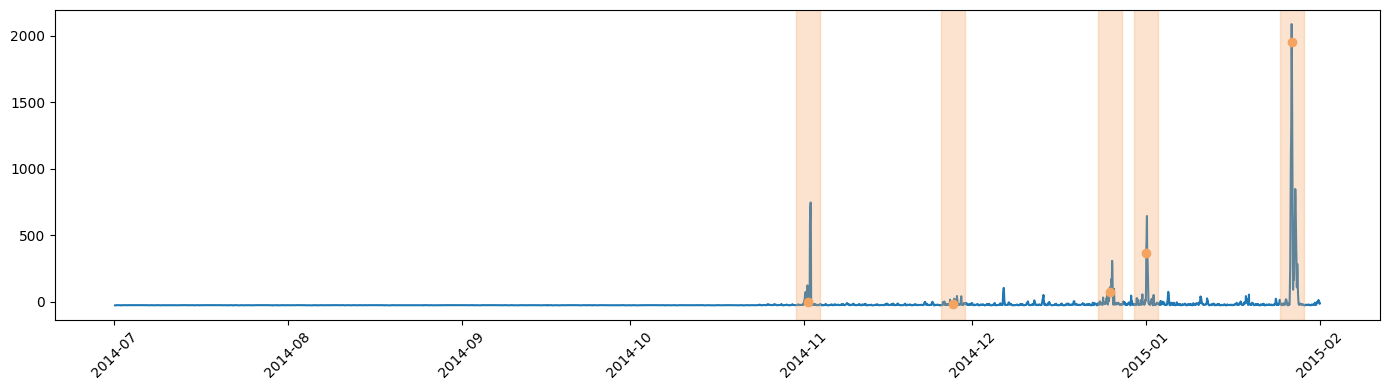

In [15]:
util.plot_series(signal, labels=labels, windows=windows, figsize=figsize)

* It's very similar to that of the other time-based model
* ...But also a bit smoother, like that of the sequence-based model

## Threshold Optimization and Evaluation

**Now we can optimize the threshold and evaluate the results**

In [11]:
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]
thr_range = np.linspace(10, 200, 100)

best_thr, best_cost = util.opt_thr(signal_opt, labels_opt, windows_opt, cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 104.04040404040404, corresponding cost: 10


Let us see the cost on the whole dataset:

In [18]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 10


This is the best result we have achieved so far!

<div class=big>What if we used this approach for the second period?</div>